# Попов Д.В 6411
## Хаотические алгоритмы шифрования изображений

In [57]:
from matplotlib import pyplot as plt
import PIL
from PIL import Image
import numpy as np
from skimage import img_as_float
from skimage import exposure
import random


def generateKey():
    lambd = random.uniform(0.0005, 0.0009)
    mu = np.sqrt(1 - lambd ** 2)  # mu [0.999999594999918, 0.9999998749999922]
    A = random.randint(1, 256)
    C = random.randint(256, 512)
    k1 = random.uniform(0.89, 0.999999)
    k2 = random.uniform(0.9, 0.999999)
    B = k1 * ((C - lambd * A) / mu)
    D = k2 * ((lambd * C - (lambd ** 2) * A - (mu ** 2) * A) / mu)
    return A, B, C, D, mu, lambd, k1, k2


def generateChaos(A, B, C, D, mu, lambd, img):
    
    x = np.zeros(img.shape[0] * img.shape[1])
    y = np.zeros(img.shape[0] * img.shape[1])
    for i in range(img.shape[0] * img.shape[1]):
        if i>30000:
            x[i] = (A * np.cos(mu * i)) + (B * np.sin(mu * i)) % 1 #аппроксимирую, так как получается очень большое 
                                                                   #вещественное число и его дробная часть теряется,
                                                                    #что приводит к 0 отсчетам хаотичной последовательности
            y[i] = (7.4 * lambd * 1 * (C * np.cos(mu * i) + D * np.sin(mu * i))) % 1
        x[i] = (7.4 * np.power(2.7, (lambd * i)) * ((A * np.cos(mu * i)) + (B * np.sin(mu * i)))) % 1
        y[i] = (7.4 * lambd * np.power(2.7, (lambd * i)) * ((C * np.cos(mu * i)) + (D * np.sin(mu * i)))) % 1
    x_1 = [num * 255 for num in x]
    y_1 = [num * 255 for num in y]
    chaos = np.array(np.int_(x_1) ^ np.int_(y_1))
    print(chaos.size)
    return chaos


def normalize():
    img_1 = Image.open('Lenna.png')
    cnt = img_1.size[0]
    for i in range(0,32):
        if cnt % 32 == 0:
            break
        cnt+=1
    img_1 = img_1.resize((cnt, cnt), PIL.Image.ANTIALIAS)
    img_1.save("Lenna.png")


def shuffleCipher(ch_r, ch_g, ch_b):
    for i in range(0, ch_r.shape[0], 32):
        for j in range(0, ch_r.shape[1], 32):
            for k in range(0, 32):
                for l in range(0, 32):
                    m = random.randint(j, 31 + j)
                    ch_r[i + k][m], ch_r[i + k][j+l] = ch_r[i + k][j+l], ch_r[i + k][m]
                    ch_g[i + k][m], ch_g[i + k][j+l] = ch_g[i + k][j+l], ch_g[i + k][m]
                    ch_b[i + k][m], ch_b[i + k][j+l] = ch_b[i + k][j+l], ch_b[i + k][m]
    return ch_r, ch_g, ch_b


def scramble(chaos_r, chaos_g, chaos_b, img):
    #img[:, :, 2], img[:, :, 1], img[:, :, 0] = shuffleCipher(img[:, :, 2], img[:, :, 1], img[:, :, 0])
    imgEncrypted = np.array(img)
    imgEncrypted[:, :, 2] = (np.int_(img[:, :, 2] * 255) ^ chaos_r.reshape((img.shape[1], img.shape[0]))) / 255
    imgEncrypted[:, :, 1] = (np.int_(img[:, :, 1] * 255) ^ chaos_g.reshape((img.shape[1], img.shape[0]))) / 255
    imgEncrypted[:, :, 0] = (np.int_(img[:, :, 0] * 255) ^ chaos_b.reshape((img.shape[1], img.shape[0]))) / 255
    imgEncrypted[:, :, 2], imgEncrypted[:, :, 1], imgEncrypted[:, :, 0] = shuffleCipher(imgEncrypted[:, :, 2],
                                                                                        imgEncrypted[:, :, 1],
                                                                                        imgEncrypted[:, :, 0])
    return imgEncrypted


def unscramble(chaos_r, chaos_g, chaos_b, imgEncrypted):
    imgDecrypted = np.array(imgEncrypted)
    imgDecrypted[:, :, 2] = abs((np.int_(imgEncrypted[:, :, 2] * 255) - chaos_r.reshape((imgEncrypted.shape[0],
                                                                                     imgEncrypted.shape[1]))) / 255)
    imgDecrypted[:, :, 1] = abs((np.int_(imgEncrypted[:, :, 1] * 255) - chaos_g.reshape((imgEncrypted.shape[0],
                                                                                     imgEncrypted.shape[1]))) / 255)
    imgDecrypted[:, :, 0] = abs((np.int_(imgEncrypted[:, :, 0] * 255) - chaos_b.reshape((imgEncrypted.shape[0],
                                                                                     imgEncrypted.shape[1]))) / 255)
    return imgDecrypted


def plot_img_and_hist(image, axes, bins=256):
    # Преобразование изображения в формат с плавающей запятой двойной точности
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_img.imshow(image, cmap=plt.cm.gray)

    # Display histogram
    ax_hist.hist(image.flatten(), bins=bins, histtype='step', color='black')
    ax_hist.set_xlabel('Pixel intensity', fontsize=25)
    ax_hist.tick_params(axis="x", labelsize=20)
    ax_hist.tick_params(axis="y", labelsize=20)

    return ax_img, ax_hist

In [58]:
normalize()
img = plt.imread("Lenna.png")


## Исходное изображение  его гистограмма

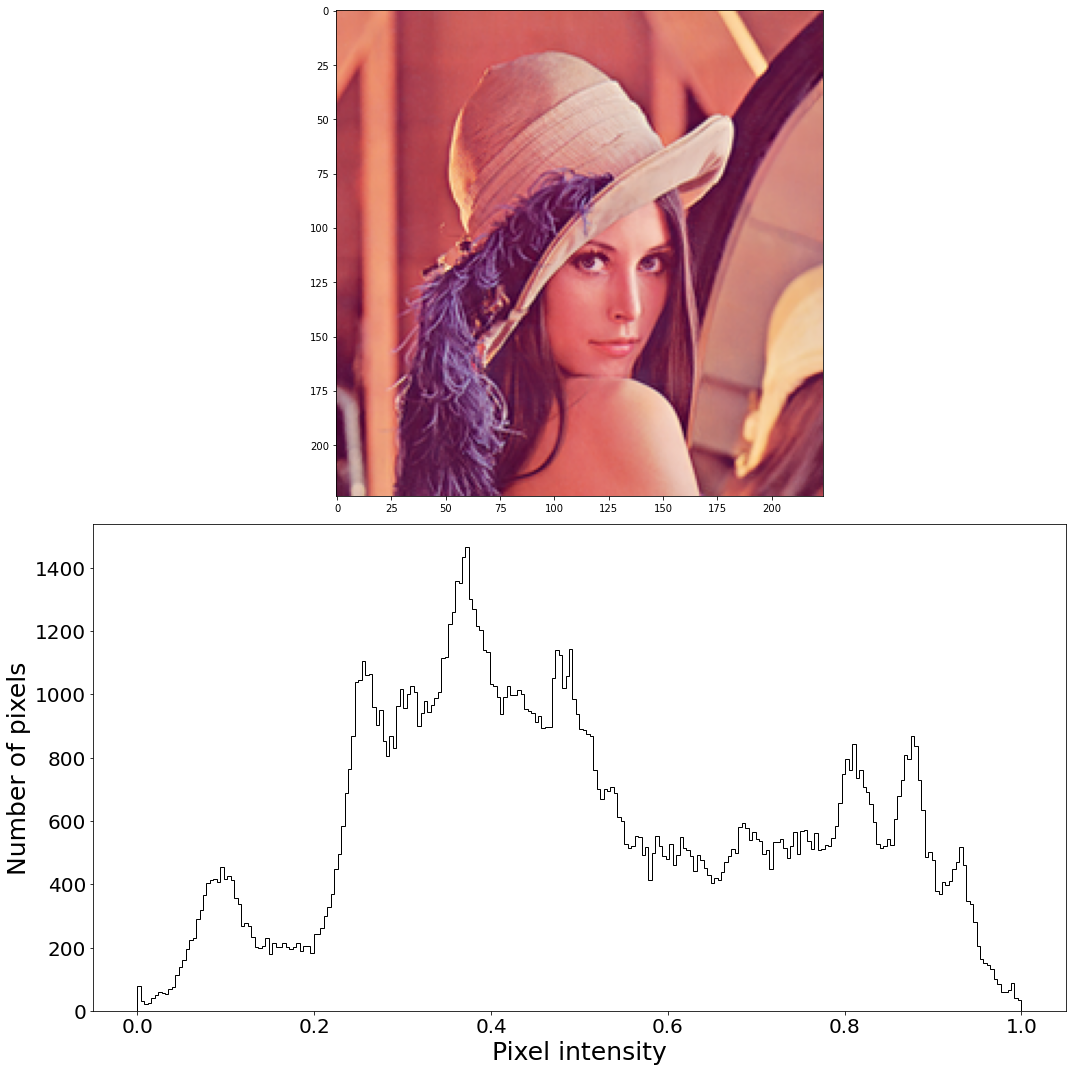

In [59]:
fig = plt.figure(figsize=(15, 15))
axes=np.zeros((2,1),dtype=object)
axes[0,0]=fig.add_subplot(211)
axes[1,0]=fig.add_subplot(212)

ax_img, ax_hist=plot_img_and_hist(img,axes[:,0])
ax_hist.set_ylabel('Number of pixels',fontsize=25)


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

## Зашифрованное изображение и его гистограмма:

50176
50176
50176


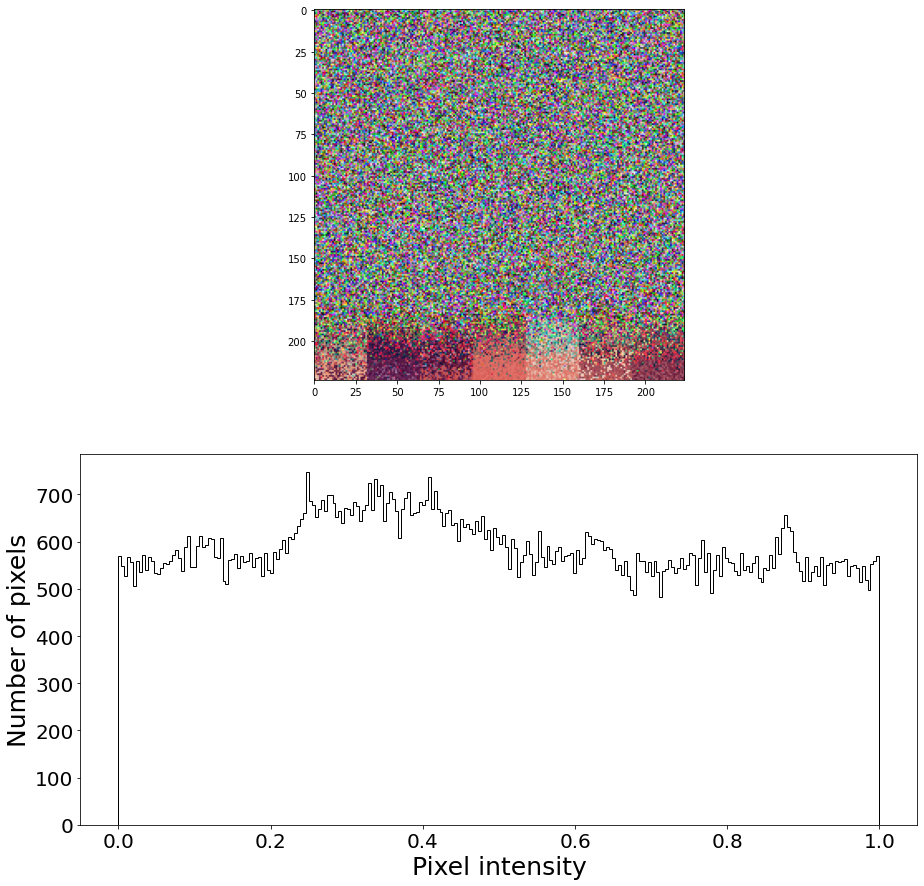

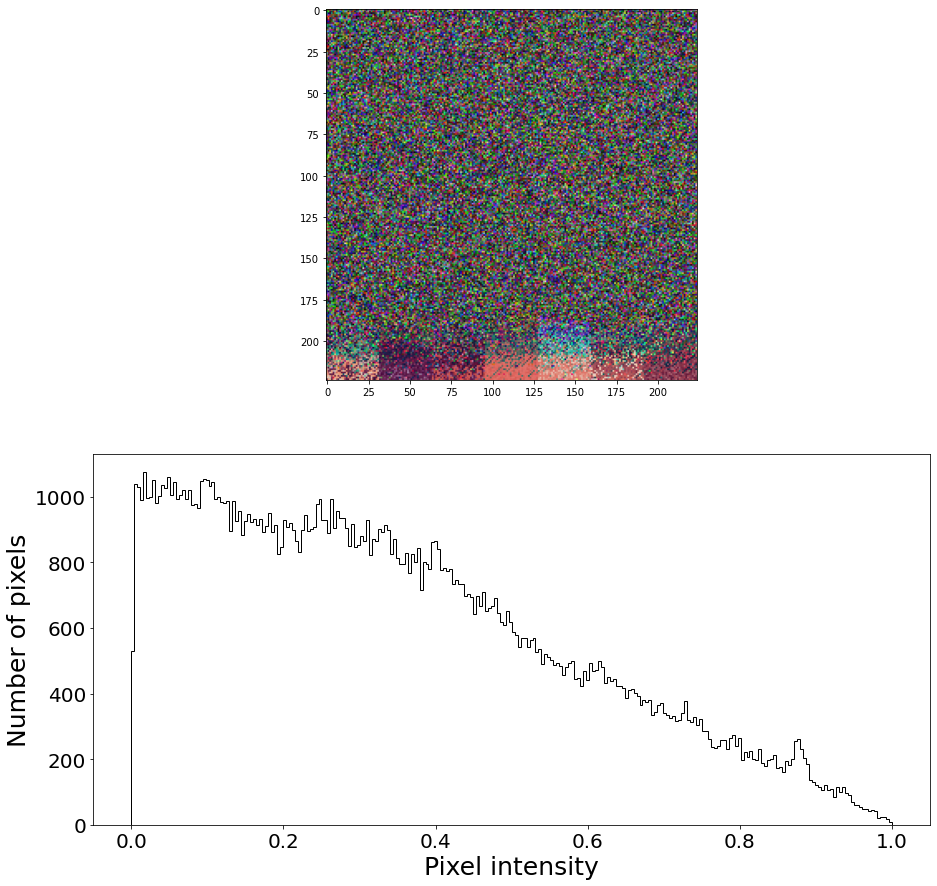

In [60]:

A_r, B_r, C_r, D_r, mu_r, lambd_r, k1_r, k2_r = generateKey()
A_g, B_g, C_g, D_g, mu_g, lambd_g, k1_g, k2_g = generateKey()
A_b, B_b, C_b, D_b, mu_b, lambd_b, k1_b, k2_b = generateKey()
    
chaos_r = generateChaos(A_r, B_r, C_r, D_r, mu_r, lambd_r, img)
chaos_g = generateChaos(A_g, B_g, C_g, D_g, mu_g, lambd_g, img)
chaos_b = generateChaos(A_b, B_b, C_b, D_b, mu_b, lambd_b, img)
    
imgEncrypted = scramble(chaos_r, chaos_g, chaos_b, img)
imgDecrypted = unscramble(chaos_r, chaos_g, chaos_b, np.array(imgEncrypted))

fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 1), dtype=object)
axes[0, 0] = fig.add_subplot(211)
axes[1, 0] = fig.add_subplot(212)

ax_img, ax_hist = plot_img_and_hist(imgEncrypted, axes[:, 0])
ax_hist.set_ylabel('Number of pixels', fontsize=25)

# prevent overlap of y-axis labels

plt.show()

fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 1), dtype=object)
axes[0, 0] = fig.add_subplot(211)
axes[1, 0] = fig.add_subplot(212)

ax_img, ax_hist = plot_img_and_hist(imgDecrypted, axes[:, 0])
ax_hist.set_ylabel('Number of pixels', fontsize=25)

# prevent overlap of y-axis labels

plt.show()



